<a href="https://colab.research.google.com/github/mohamed32145/U-net-image-segmantion-paper-implemeantion/blob/main/DLfinal1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import random
from scipy import ndimage
from scipy.ndimage import distance_transform_edt

# For Google Colab - mount drive if needed
def mount_drive():
    """Mount Google Drive in Colab environment"""
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Google Drive mounted successfully!")
    except ImportError:
        print("Not running in Google Colab, skipping drive mount")

Mounted at /content/drive
Google Drive mounted successfully!
Using device: cuda
Found train images directory with 30 files
Found train labels directory with 30 files
Found test images directory with 30 files
Found test labels directory with 30 files
Found 30 valid image-mask pairs in imgs
Found 30 valid image-mask pairs in imgs
Dataset sizes:
Train: 24 samples
Validation: 6 samples
Test: 30 samples
Model has 31036481 parameters
Starting training...
Train Epoch: 0 [0/24 (0%)]	Loss: 0.588676
Epoch 1/30:
Train Loss: 0.5457, Val Loss: 0.6590, Val Dice: 0.8697
New best model saved with Dice: 0.8697
------------------------------------------------------------
Train Epoch: 1 [0/24 (0%)]	Loss: 0.523696
Epoch 2/30:
Train Loss: 0.4979, Val Loss: 0.6158, Val Dice: 0.8697
------------------------------------------------------------
Train Epoch: 2 [0/24 (0%)]	Loss: 0.481703
Epoch 3/30:
Train Loss: 0.4693, Val Loss: 0.5575, Val Dice: 0.8697
-----------------------------------------------------------

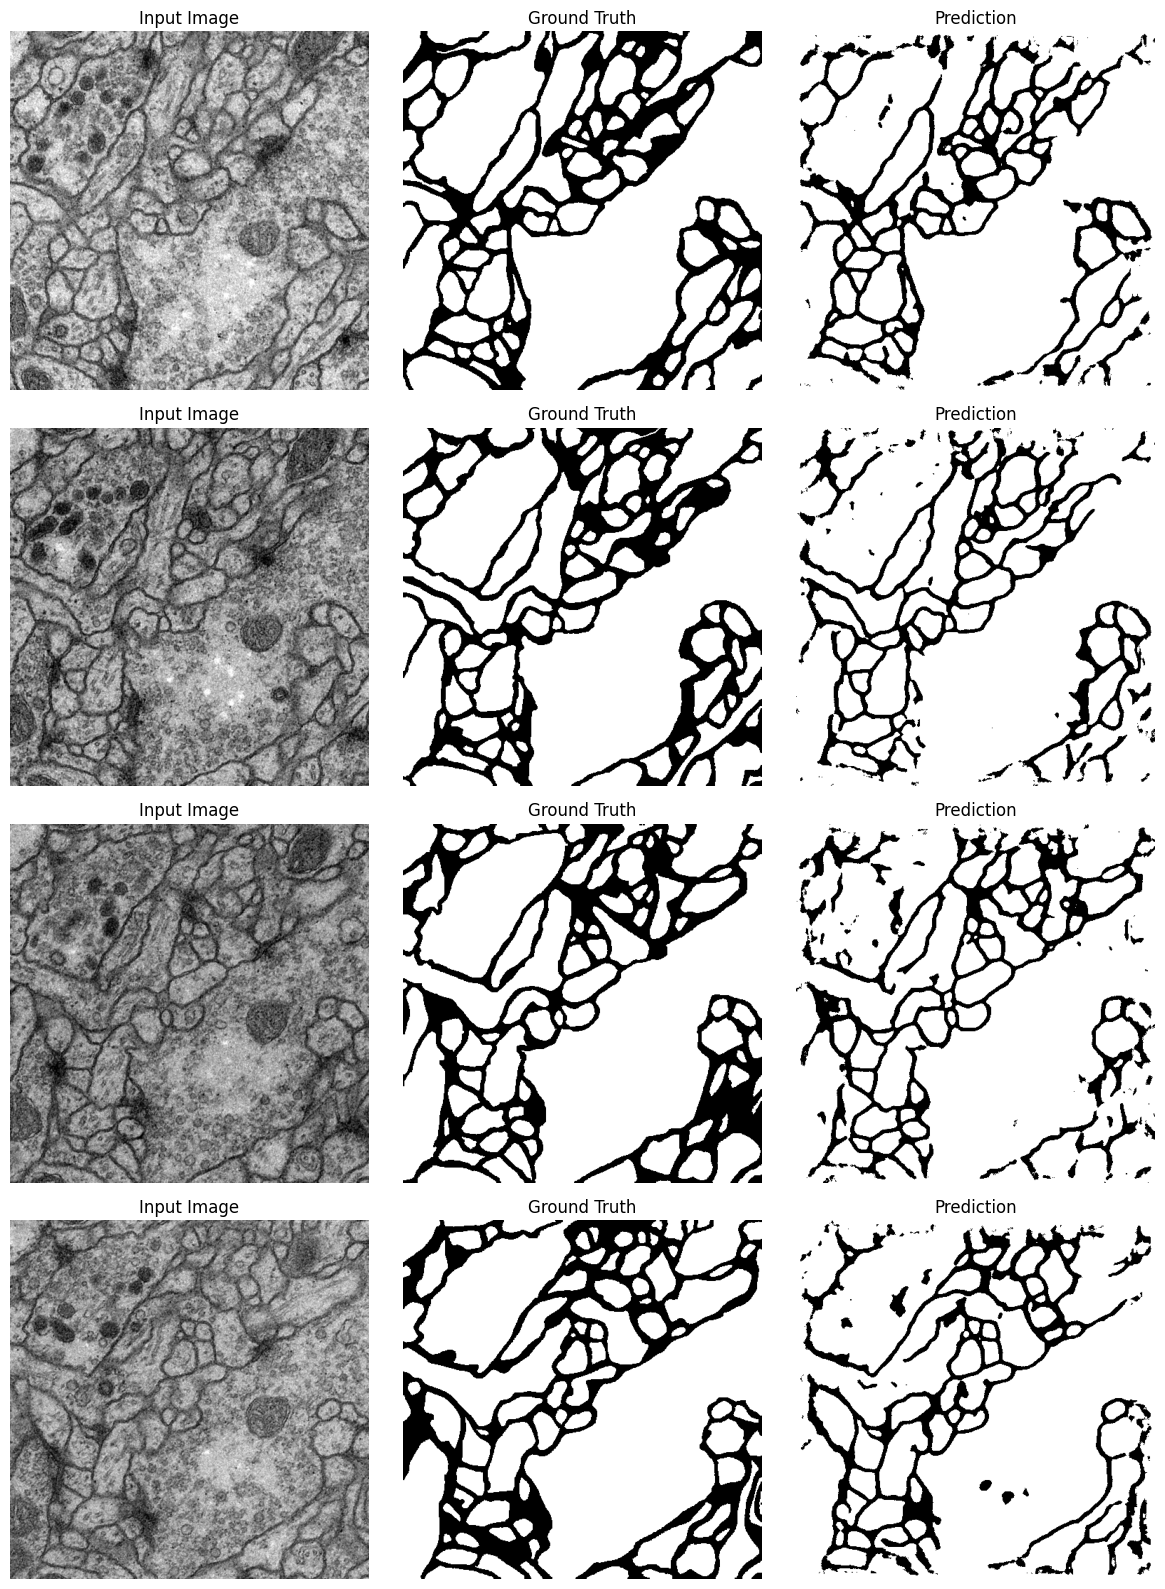

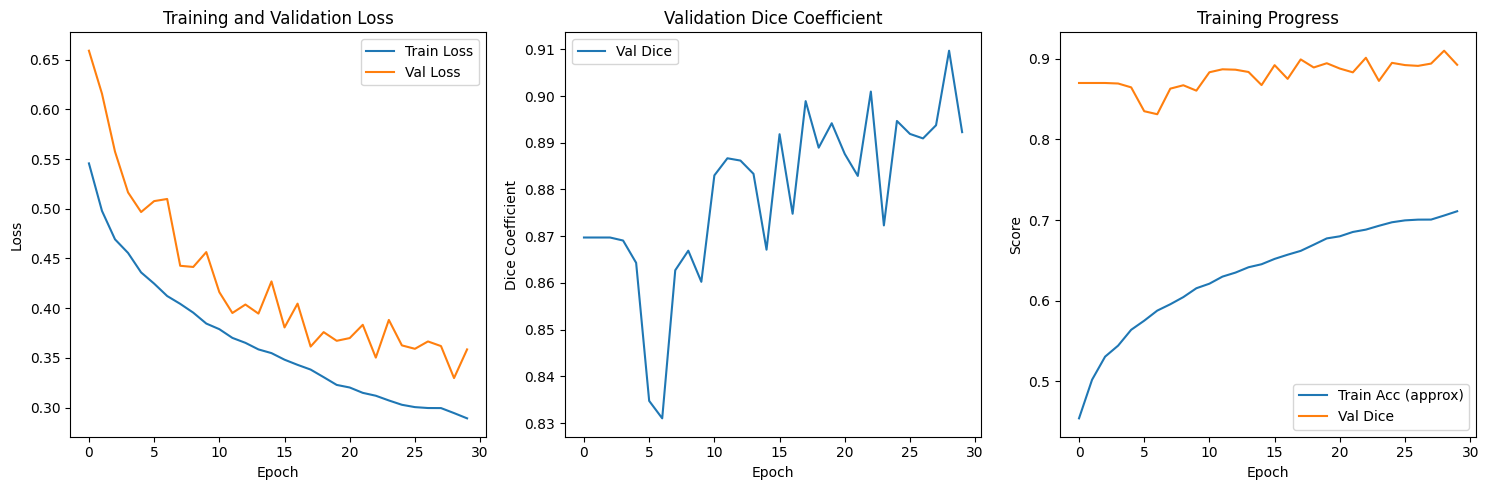

In [ ]:

# using BCEWithLogitsLoss (Binary Cross-Entropy with Logits Loss) loss function

class DoubleConv(nn.Module):
    """(convolution => BN => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=0, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class ISBI2012Dataset(Dataset):
    """ISBI 2012 EM Segmentation Challenge Dataset"""

    def __init__(self, image_dir, mask_dir, transform=None, augment=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.augment = augment

        # Get all image files (common formats for ISBI data)
        self.images = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.tif', '.tiff', '.jpg', '.jpeg'))]
        self.images.sort()

        # Verify that corresponding masks exist
        valid_images = []
        for img_name in self.images:
            mask_path = os.path.join(mask_dir, img_name)
            if os.path.exists(mask_path):
                valid_images.append(img_name)
            else:
                print(f"Warning: No corresponding mask found for {img_name}")

        self.images = valid_images
        print(f"Found {len(self.images)} valid image-mask pairs in {os.path.basename(image_dir)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Load image and mask
        try:
            image = Image.open(img_path).convert('L')  # Grayscale
            mask = Image.open(mask_path).convert('L')   # Grayscale
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
            # Return a dummy tensor in case of error
            return torch.zeros(1, 256, 256), torch.zeros(256, 256, dtype=torch.long)

        # Convert to numpy arrays
        image = np.array(image)
        mask = np.array(mask)

        # Normalize image to [0, 1]
        image = image.astype(np.float32) / 255.0

        # Normalize mask to {0, 1}
        mask = (mask > 127).astype(np.float32)

        # Data augmentation
        if self.augment:
            # Random horizontal flip
            if random.random() > 0.5:
                image = np.fliplr(image).copy()
                mask = np.fliplr(mask).copy()

            # Random vertical flip
            if random.random() > 0.5:
                image = np.flipud(image).copy()
                mask = np.flipud(mask).copy()

            # Random rotation (90, 180, 270 degrees)
            if random.random() > 0.75:
                k = random.randint(1, 3)
                image = np.rot90(image, k).copy()
                mask = np.rot90(mask, k).copy()

        # Ensure arrays are contiguous before converting to tensor
        image = np.ascontiguousarray(image)
        mask = np.ascontiguousarray(mask)

        # Convert to tensor
        image = torch.from_numpy(image).unsqueeze(0)  # Add channel dimension
        mask = torch.from_numpy(mask).long()

        return image, mask

def dice_coefficient(pred, target, smooth=1e-6):
    """Calculate Dice coefficient"""
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    # Flatten tensors for calculation
    pred_flat = pred.view(pred.size(0), -1)
    target_flat = target.view(target.size(0), -1)

    intersection = (pred_flat * target_flat).sum(dim=1)
    union = pred_flat.sum(dim=1) + target_flat.sum(dim=1)

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def train_model(model, train_loader, val_loader, num_epochs=30, learning_rate=1e-4, device='cuda'):
    """Train the U-Net model"""

    # Loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

    # Training history
    train_losses = []
    val_losses = []
    val_dices = []

    best_dice = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device).float()

            optimizer.zero_grad()
            output = model(data)

            # Resize output to match target size if necessary
            if output.size() != target.size():
                output = F.interpolate(output, size=target.shape[-2:], mode='bilinear', align_corners=False)

            loss = criterion(output.squeeze(1), target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device).float()
                output = model(data)

                # Resize output to match target size if necessary
                if output.size() != target.size():
                    output = F.interpolate(output, size=target.shape[-2:], mode='bilinear', align_corners=False)

                val_loss += criterion(output.squeeze(1), target).item()
                val_dice += dice_coefficient(output.squeeze(1), target).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_dice /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_dices.append(val_dice)

        # Learning rate scheduling
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}')

        # Save best model
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), 'best_unet_isbi2012.pth')
            print(f'New best model saved with Dice: {best_dice:.4f}')

        print('-' * 60)

    return train_losses, val_losses, val_dices

def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate the trained model"""
    model.eval()
    total_dice = 0.0
    total_accuracy = 0.0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Resize output to match target size if necessary
            if output.size() != target.size():
                output = F.interpolate(output, size=target.shape[-2:], mode='bilinear', align_corners=False)

            # Convert to predictions
            pred = torch.sigmoid(output.squeeze(1))
            pred_binary = (pred > 0.5).float()

            # Calculate metrics
            dice = dice_coefficient(output.squeeze(1), target.float())
            total_dice += dice.item()

            # Flatten for accuracy calculation
            pred_flat = pred_binary.cpu().numpy().flatten()
            target_flat = target.cpu().numpy().flatten()
            accuracy = accuracy_score(target_flat, pred_flat)
            total_accuracy += accuracy

    avg_dice = total_dice / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader)

    print(f'Test Results:')
    print(f'Average Dice Coefficient: {avg_dice:.4f}')
    print(f'Average Accuracy: {avg_accuracy:.4f}')

    return avg_dice, avg_accuracy

def visualize_predictions(model, test_loader, device='cuda', num_samples=4):
    """Visualize model predictions"""
    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= num_samples:
                break

            data, target = data.to(device), target.to(device)
            output = model(data)

            # Get first sample from batch
            img = data[0, 0].cpu().numpy()
            true_mask = target[0].cpu().numpy()
            pred_mask = torch.sigmoid(output[0, 0]).cpu().numpy()
            pred_binary = (pred_mask > 0.5).astype(np.float32)

            # Plot
            axes[i, 0].imshow(img, cmap='gray')
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(true_mask, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(pred_binary, cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig('unet_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Path to your Google Drive ISBIdata folder
    root_dir = '/content/drive/MyDrive/ISBIdata'

    # Dataset paths for your data structure
    train_image_dir = os.path.join(root_dir, 'train', 'imgs')
    train_mask_dir = os.path.join(root_dir, 'train', 'labels')
    test_image_dir = os.path.join(root_dir, 'test', 'imgs')
    test_mask_dir = os.path.join(root_dir, 'test', 'labels')

    # Check if directories exist
    for dir_path, name in [(train_image_dir, 'train images'), (train_mask_dir, 'train labels'),
                          (test_image_dir, 'test images'), (test_mask_dir, 'test labels')]:
        if not os.path.exists(dir_path):
            print(f"Warning: {name} directory not found at {dir_path}")
        else:
            print(f"Found {name} directory with {len(os.listdir(dir_path))} files")

    # Create full training dataset
    full_train_dataset = ISBI2012Dataset(train_image_dir, train_mask_dir, augment=True)

    # Split training data into train/validation (80/20 split)
    train_size = int(0.8 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

    # Create test dataset
    test_dataset = ISBI2012Dataset(test_image_dir, test_mask_dir, augment=False)

    print(f"Dataset sizes:")
    print(f"Train: {len(train_dataset)} samples")
    print(f"Validation: {len(val_dataset)} samples")
    print(f"Test: {len(test_dataset)} samples")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

    # Initialize model
    model = UNet(n_channels=1, n_classes=1, bilinear=False).to(device)

    print(f'Model has {sum(p.numel() for p in model.parameters())} parameters')

    # Train model
    print("Starting training...")
    train_losses, val_losses, val_dices = train_model(
        model, train_loader, val_loader,
        num_epochs=30, learning_rate=1e-4, device=device
    )

    # Load best model
    model.load_state_dict(torch.load('best_unet_isbi2012.pth'))

    # Evaluate on test set
    print("Evaluating on test set...")
    test_dice, test_accuracy = evaluate_model(model, test_loader, device)

    # Visualize predictions
    print("Generating visualizations...")
    visualize_predictions(model, test_loader, device)

    # Plot training curves
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 3, 2)
    plt.plot(val_dices, label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    plt.title('Validation Dice Coefficient')

    plt.subplot(1, 3, 3)
    plt.plot([1-loss for loss in train_losses], label='Train Acc (approx)')
    plt.plot(val_dices, label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Training Progress')

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

if __name__ == '__main__':
    # Mount Google Drive if running in Colab
    mount_drive()
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
Using device: cuda
Found train images directory with 30 files
Found train labels directory with 30 files
Found test images directory with 30 files
Found test labels directory with 30 files
Found 30 valid image-mask pairs in imgs
Found 30 valid image-mask pairs in imgs
Dataset sizes:
Train: 24 samples
Validation: 6 samples
Test: 30 samples
Model has 31036546 parameters
Starting training...
Train Epoch: 0 [0/24 (0%)]	Loss: 1.395976
Epoch 1/30:
Train Loss: 1.3775, Val Loss: 1.5084, Val Dice: 0.0000
New best model saved with Dice: 0.0000
------------------------------------------------------------
Train Epoch: 1 [0/24 (0%)]	Loss: 1.347679
Epoch 2/30:
Train Loss: 1.3118, Val Loss: 1.5347, Val Dice: 0.0000
New best model saved with Dice: 0.0000
------------------------------------------------------------
Train Epoch: 2 [0/24 (0%)]

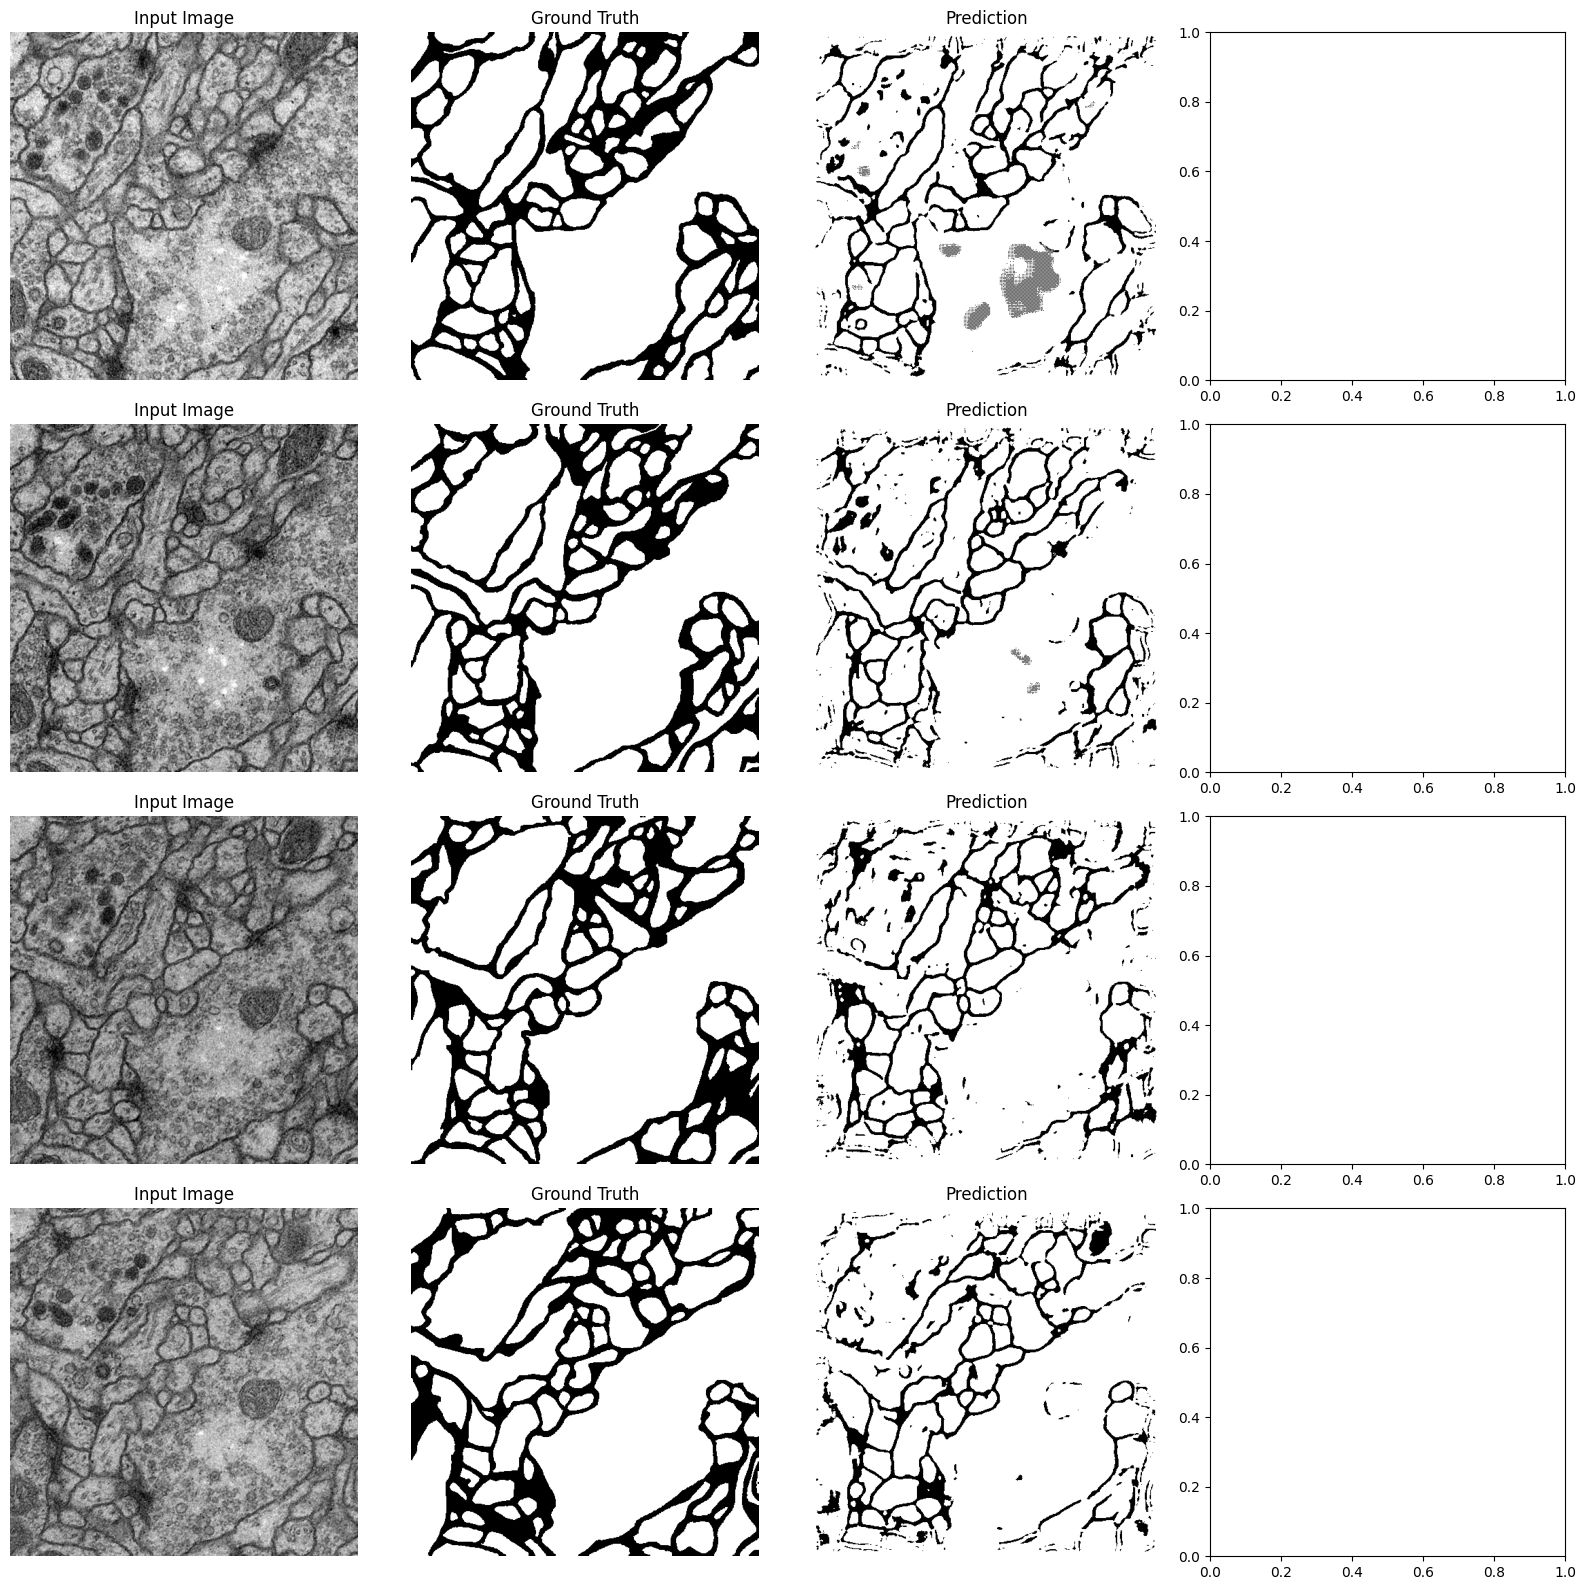

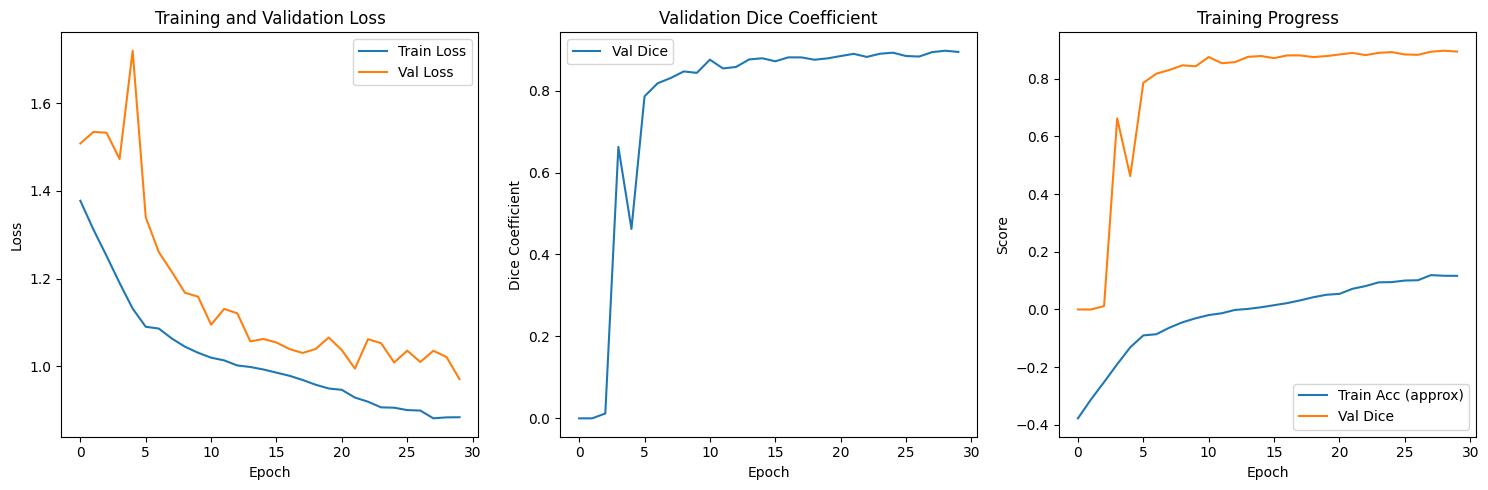

In [ ]:
# with original weighted cross-entropy loss functionw (x) = w_c(x) + w_0 · exp(-((d_1(x) + d_2(x))^2)/(2σ^2))

def visualize_predictions(model, test_loader, device='cuda', num_samples=4):
    """Visualize model predictions"""
    model.eval()

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))

    with torch.no_grad():
        for i, (data, target, weight_maps) in enumerate(test_loader):
            if i >= num_samples:
                break

            data, target, weight_maps = data.to(device), target.to(device), weight_maps.to(device)
            output = model(data)

            # Get first sample from batch
            img = data[0, 0].cpu().numpy()
            true_mask = target[0].cpu().numpy()
            weight_map = weight_maps[0].cpu().numpy()

            # Get prediction
            pred_probs = F.softmax(output, dim=1)
            pred_mask = pred_probs[0, 1].cpu().numpy()  # Foreground probability
            pred_binary = (pred_mask > 0.5).astype(np.float32)

            # Plot
            axes[i, 0].imshow(img, cmap='gray')
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(true_mask, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(pred_binary, cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')

            # axes[i, 3].imshow(weight_map, cmap='hot')
            # axes[i, 3].set_title('Weight Map')
            # axes[i, 3].axis('off')

    plt.tight_layout()
    plt.savefig('unet_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()


def compute_weight_map(mask, w0=10, sigma=5):
    """
    Compute weight map as described in U-Net paper
    w(x) = w_c(x) + w0 * exp(-((d1(x) + d2(x))^2) / (2*sigma^2))

    Args:
        mask: binary mask (0 for background, 1 for foreground)
        w0: weight parameter (default 10)
        sigma: sigma parameter (default 5)
    """
    # Convert to numpy if tensor
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    # Ensure binary mask
    mask = (mask > 0.5).astype(np.uint8)

    # Class frequency balancing - give more weight to rare class
    class_weights = np.zeros_like(mask, dtype=np.float32)
    total_pixels = mask.size

    # Weight for background (0) and foreground (1)
    bg_pixels = np.sum(mask == 0)
    fg_pixels = np.sum(mask == 1)

    if bg_pixels > 0:
        class_weights[mask == 0] = total_pixels / (2.0 * bg_pixels)
    if fg_pixels > 0:
        class_weights[mask == 1] = total_pixels / (2.0 * fg_pixels)

    # Find borders between cells (for separation)
    # For binary segmentation, we focus on foreground boundaries
    foreground = (mask == 1).astype(np.uint8)

    # Find connected components
    labeled_mask, num_labels = ndimage.label(foreground)

    if num_labels <= 1:
        # No separation needed, return class weights only
        return class_weights

    # Calculate distance to borders
    border_weight = np.zeros_like(mask, dtype=np.float32)

    # For each pair of adjacent components, calculate boundary weights
    for label_id in range(1, num_labels + 1):
        # Get current component
        component = (labeled_mask == label_id).astype(np.uint8)

        # Get distance transform (distance to nearest background)
        dist_to_bg = distance_transform_edt(component)

        # Find component boundaries (pixels with small distance to background)
        boundary = (dist_to_bg <= 2) & (component == 1)

        if np.any(boundary):
            # Calculate distances to nearest and second nearest boundaries
            boundary_coords = np.where(boundary)

            for i in range(len(boundary_coords[0])):
                y, x = boundary_coords[0][i], boundary_coords[1][i]

                # Simple approximation: use distance to background as d1+d2
                d1_plus_d2 = max(1, dist_to_bg[y, x])  # Avoid division by zero

                # Apply weight formula
                weight = w0 * np.exp(-((d1_plus_d2)**2) / (2 * sigma**2))
                border_weight[y, x] = weight

    # Combine class weights and border weights
    total_weight = class_weights + border_weight

    return total_weight

class WeightedCrossEntropyLoss(nn.Module):
    """
    Weighted Cross-Entropy Loss as used in original U-Net paper
    """
    def __init__(self):
        super(WeightedCrossEntropyLoss, self).__init__()

    def forward(self, outputs, targets, weight_maps=None):
        """
        Args:
            outputs: model predictions (logits) [B, C, H, W]
            targets: ground truth labels [B, H, W]
            weight_maps: pixel-wise weights [B, H, W]
        """
        # Apply softmax to get probabilities
        probs = F.softmax(outputs, dim=1)

        # Convert targets to one-hot encoding
        targets_one_hot = F.one_hot(targets.long(), num_classes=outputs.size(1)).permute(0, 3, 1, 2).float()

        # Calculate cross-entropy loss
        log_probs = torch.log(probs + 1e-8)  # Add small epsilon for numerical stability
        ce_loss = -targets_one_hot * log_probs
        ce_loss = ce_loss.sum(dim=1)  # Sum over classes

        # Apply weight maps if provided
        if weight_maps is not None:
            ce_loss = ce_loss * weight_maps

        return ce_loss.mean()

def dice_coefficient(pred, target, smooth=1e-6):
    """Calculate Dice coefficient"""
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    # Flatten tensors for calculation
    pred_flat = pred.view(pred.size(0), -1)
    target_flat = target.view(target.size(0), -1)

    intersection = (pred_flat * target_flat).sum(dim=1)
    union = pred_flat.sum(dim=1) + target_flat.sum(dim=1)

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

class DoubleConv(nn.Module):
    """(convolution => BN => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=0, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class ISBI2012Dataset(Dataset):
    """ISBI 2012 EM Segmentation Challenge Dataset"""

    def __init__(self, image_dir, mask_dir, transform=None, augment=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.augment = augment

        # Get all image files (common formats for ISBI data)
        self.images = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.tif', '.tiff', '.jpg', '.jpeg'))]
        self.images.sort()

        # Verify that corresponding masks exist
        valid_images = []
        for img_name in self.images:
            mask_path = os.path.join(mask_dir, img_name)
            if os.path.exists(mask_path):
                valid_images.append(img_name)
            else:
                print(f"Warning: No corresponding mask found for {img_name}")

        self.images = valid_images
        print(f"Found {len(self.images)} valid image-mask pairs in {os.path.basename(image_dir)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Load image and mask
        try:
            image = Image.open(img_path).convert('L')  # Grayscale
            mask = Image.open(mask_path).convert('L')   # Grayscale
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
            # Return a dummy tensor in case of error
            return torch.zeros(1, 256, 256), torch.zeros(256, 256, dtype=torch.long), torch.zeros(256, 256) # Also return a dummy weight map

        # Convert to numpy arrays
        image = np.array(image)
        mask = np.array(mask)

        # Normalize image to [0, 1]
        image = image.astype(np.float32) / 255.0

        # Normalize mask to {0, 1}
        mask = (mask > 127).astype(np.float32)

        # Data augmentation
        if self.augment:
            # Random horizontal flip
            if random.random() > 0.5:
                image = np.fliplr(image).copy()
                mask = np.fliplr(mask).copy()

            # Random vertical flip
            if random.random() > 0.5:
                image = np.flipud(image).copy()
                mask = np.flipud(mask).copy()

            # Random rotation (90, 180, 270 degrees)
            if random.random() > 0.75:
                k = random.randint(1, 3)
                image = np.rot90(image, k).copy()
                mask = np.rot90(mask, k).copy()

        # Ensure arrays are contiguous before converting to tensor
        image = np.ascontiguousarray(image)
        mask = np.ascontiguousarray(mask)

        # Calculate weight map
        weight_map = compute_weight_map(mask)

        # Convert to tensor
        image = torch.from_numpy(image).unsqueeze(0)  # Add channel dimension
        mask = torch.from_numpy(mask).long()
        weight_map = torch.from_numpy(weight_map).float()


        return image, mask, weight_map

def train_model(model, train_loader, val_loader, num_epochs=30, learning_rate=1e-4, device='cuda'):
    """Train the U-Net model"""

    # Loss function and optimizer - using original U-Net weighted cross-entropy
    criterion = WeightedCrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

    # Training history
    train_losses = []
    val_losses = []
    val_dices = []

    best_dice = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch_idx, (data, target, weight_maps) in enumerate(train_loader):
            data, target, weight_maps = data.to(device), target.to(device), weight_maps.to(device)

            optimizer.zero_grad()
            output = model(data)

            # Resize output to match target size if necessary
            if output.size()[-2:] != target.size()[-2:]:
                output = F.interpolate(output, size=target.shape[-2:], mode='bilinear', align_corners=False)
                # Also resize weight maps to match
                weight_maps = F.interpolate(weight_maps.unsqueeze(1), size=target.shape[-2:], mode='bilinear', align_corners=False).squeeze(1)

            loss = criterion(output, target, weight_maps)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0

        with torch.no_grad():
            for data, target, weight_maps in val_loader:
                data, target, weight_maps = data.to(device), target.to(device), weight_maps.to(device)
                output = model(data)

                # Resize output to match target size if necessary
                if output.size()[-2:] != target.size()[-2:]:
                    output = F.interpolate(output, size=target.shape[-2:], mode='bilinear', align_corners=False)
                    weight_maps = F.interpolate(weight_maps.unsqueeze(1), size=target.shape[-2:], mode='bilinear', align_corners=False).squeeze(1)

                val_loss += criterion(output, target, weight_maps).item()

                # For dice calculation, convert to binary predictions
                pred_probs = F.softmax(output, dim=1)
                pred_binary = (pred_probs[:, 1] > 0.5).float()  # Get foreground class
                val_dice += dice_coefficient(pred_binary.unsqueeze(1), target.float().unsqueeze(1)).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_dice /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_dices.append(val_dice)

        # Learning rate scheduling
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}')

        # Save best model
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), 'best_unet_isbi2012.pth')
            print(f'New best model saved with Dice: {best_dice:.4f}')

        print('-' * 60)

    return train_losses, val_losses, val_dices

def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate the trained model"""
    model.eval()
    total_dice = 0.0
    total_accuracy = 0.0

    with torch.no_grad():
        for data, target, weight_maps in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Resize output to match target size if necessary
            if output.size()[-2:] != target.size()[-2:]:
                output = F.interpolate(output, size=target.shape[-2:], mode='bilinear', align_corners=False)

            # Convert to predictions - get foreground class probabilities
            pred_probs = F.softmax(output, dim=1)
            pred_binary = (pred_probs[:, 1] > 0.5).float()

            # Calculate metrics
            dice = dice_coefficient(pred_binary.unsqueeze(1), target.float().unsqueeze(1))
            total_dice += dice.item()

            # Flatten for accuracy calculation
            pred_flat = pred_binary.cpu().numpy().flatten()
            target_flat = target.cpu().numpy().flatten()
            accuracy = accuracy_score(target_flat, pred_flat)
            total_accuracy += accuracy

    avg_dice = total_dice / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader)

    print(f'Test Results:')
    print(f'Average Dice Coefficient: {avg_dice:.4f}')
    print(f'Average Accuracy: {avg_accuracy:.4f}')

    return avg_dice, avg_accuracy

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Path to your Google Drive ISBIdata folder
    root_dir = '/content/drive/MyDrive/ISBIdata'

    # Dataset paths for your data structure
    train_image_dir = os.path.join(root_dir, 'train', 'imgs')
    train_mask_dir = os.path.join(root_dir, 'train', 'labels')
    test_image_dir = os.path.join(root_dir, 'test', 'imgs')
    test_mask_dir = os.path.join(root_dir, 'test', 'labels')

    # Check if directories exist
    for dir_path, name in [(train_image_dir, 'train images'), (train_mask_dir, 'train labels'),
                          (test_image_dir, 'test images'), (test_mask_dir, 'test labels')]:
        if not os.path.exists(dir_path):
            print(f"Warning: {name} directory not found at {dir_path}")
        else:
            print(f"Found {name} directory with {len(os.listdir(dir_path))} files")

    # Create full training dataset
    full_train_dataset = ISBI2012Dataset(train_image_dir, train_mask_dir, augment=True)

    # Split training data into train/validation (80/20 split)
    train_size = int(0.8 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

    # Create test dataset
    test_dataset = ISBI2012Dataset(test_image_dir, test_mask_dir, augment=False)

    print(f"Dataset sizes:")
    print(f"Train: {len(train_dataset)} samples")
    print(f"Validation: {len(val_dataset)} samples")
    print(f"Test: {len(test_dataset)} samples")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

    # Initialize model - note: 2 classes for binary segmentation (background + foreground)
    model = UNet(n_channels=1, n_classes=2, bilinear=False).to(device)

    print(f'Model has {sum(p.numel() for p in model.parameters())} parameters')

    # Train model
    print("Starting training...")
    train_losses, val_losses, val_dices = train_model(
        model, train_loader, val_loader,
        num_epochs=30, learning_rate=1e-4, device=device
    )

    # Load best model
    model.load_state_dict(torch.load('best_unet_isbi2012.pth'))

    # Evaluate on test set
    print("Evaluating on test set...")
    test_dice, test_accuracy = evaluate_model(model, test_loader, device)

    # Visualize predictions
    print("Generating visualizations...")
    visualize_predictions(model, test_loader, device)

    # Plot training curves
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 3, 2)
    plt.plot(val_dices, label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    plt.title('Validation Dice Coefficient')

    plt.subplot(1, 3, 3)
    plt.plot([1-loss for loss in train_losses], label='Train Acc (approx)')
    plt.plot(val_dices, label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Training Progress')

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

if __name__ == '__main__':
    # Mount Google Drive if running in Colab
    mount_drive()
    main()